显示点扩展函数

显示点目标

[[4, 189, 156, 5, 5, 0.39947291792892736, 0.9064895317550901, 0.3017353483940441, 0.3389828011076817, 1.0, 0.31131756731178895, 192, 192]]


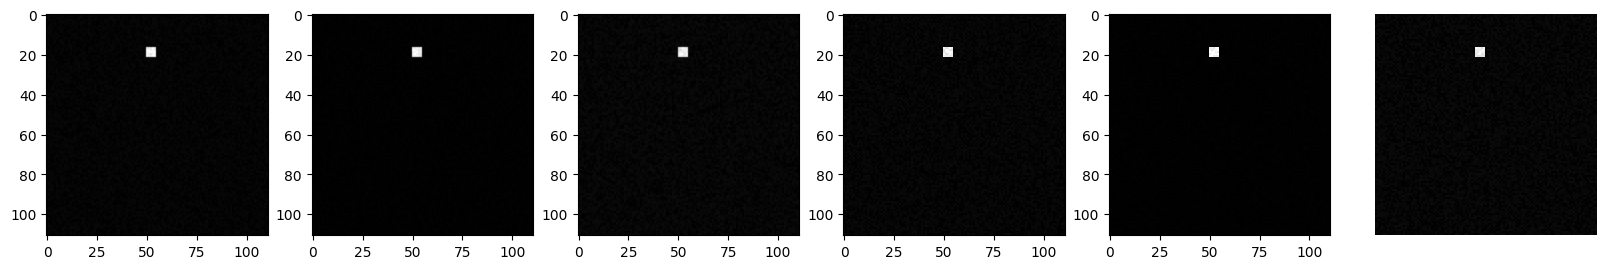

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from lib.utils.PointSample import gen_merge_sample
import cv2
import os
import json

otf_list = np.load("../data/PSF0620_04_4_40.npy")
labels = [0,1,2,3,4,5]
obj_width = 111

sample, target = gen_merge_sample(otf_list, labels, obj_width, point_type="ones_rand", weight_mode = "rand", have_noise = True , noise_sig = 0.01, nsr=0.1)
print(target)
rect_patch = np.load("rect_patchs.npy")
num, h,w = rect_patch.shape
plt.rcParams['figure.figsize'] = (20.0, 5.0) 
fig, ax = plt.subplots(1,num)
for i in range(num):
    ax[i].imshow(rect_patch[i,:,:],cmap="gray")
    cv2.imwrite("rect_patch_{}.bmp".format(i), rect_patch[i,:,:] * 255)

plt.axis("off")
plt.show()
path = "."
np.save(os.path.join(path,"sample_{:05d}.npy".format(1)),sample)
with open(os.path.join(path,"sample_{:05d}.json".format(1)), "w") as fp:
    json.dump(target, fp)


显示光谱压缩图像

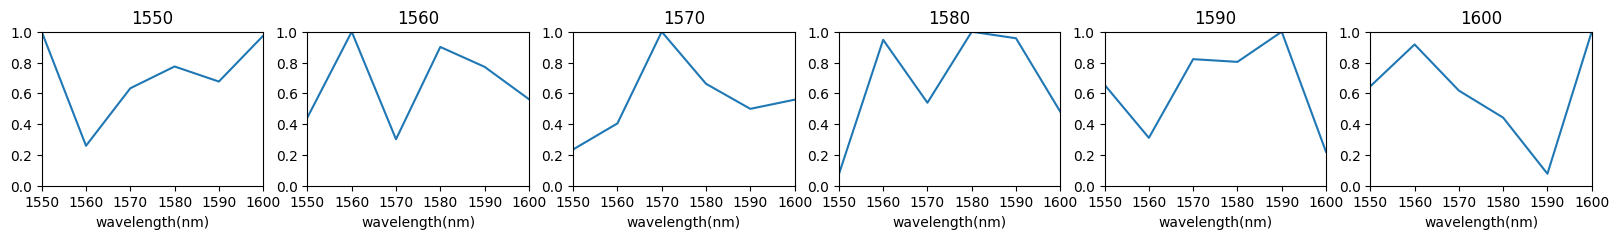

In [62]:

import matplotlib.pyplot as plt
import random
from lib.utils.PointSample import gen_weight_and_label

wave_count = 6
labels = [0,1,2,3,4,5]
x = [1550,1560,1570,1580,1590,1600]
fig, ax = plt.subplots(1,6)
for i in range(6):
    weight0 , label0 = gen_weight_and_label(wave_count, labels = [labels[i]], weight_mode="rand", have_noise = True)
    ax[i].plot(x,weight0)    
    ax[i].set_title(str(x[i]))
    ax[i].set_xlabel("wavelength(nm)")
    ax[i].set_xlim((1550,1600))
    ax[i].set_ylim((0,1))
plt.rcParams['figure.figsize'] = (20.0, 2.0) 
plt.xlim((1550,1600))
plt.show()

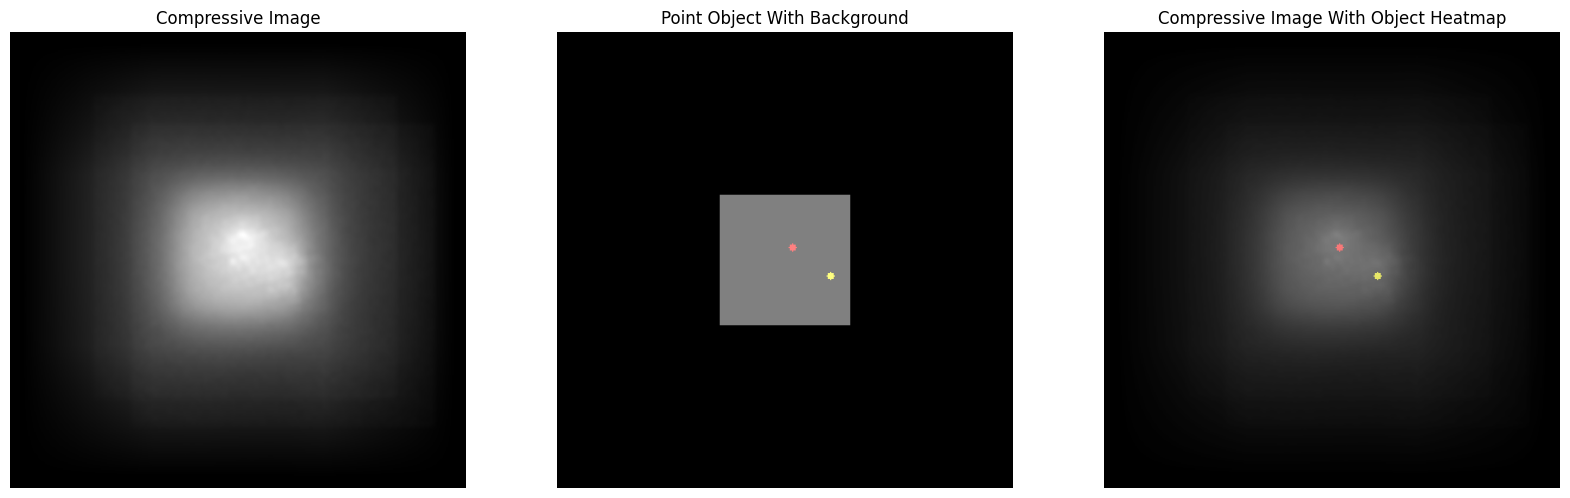

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from lib.utils.image import draw_umich_gaussian, draw_msra_gaussian


def gen_background(heatmap, anns, width = 111):
    h,w=heatmap.shape
    mask = np.zeros((h,w,3))
    rectx = anns[0][-2]
    recty = anns[0][-1]

    x1 = rectx - width//2
    x2 = rectx + width//2
    y1 = recty - width//2
    y2 = recty + width//2
    mask[y1:y2, x1:x2, :] = 1
    return np.ascontiguousarray(mask * 255 , dtype=np.uint8)


def gen_color(cls):
    cmap = {0:(139, 0 , 255),
            1:(0, 0, 255), 
            2:(0, 127, 255), 
            3:(0, 255, 0), 
            4:(255, 255, 0), 
            5:(255, 0, 0)}
    return cmap[cls]


def add_gt_mask(heatmap, anns, radius=3, factor= 1.0): 
    h,w=heatmap.shape
    mask = np.zeros((h,w,3))
    mask = np.ascontiguousarray(mask, dtype=np.uint8)
    for ann in anns:
        px = int(ann[1])
        py = int(ann[2])
        cls = int(ann[0])
        color = gen_color(cls)
        cv2.circle(mask, (px,py), radius, color,-1)
    return mask

for idx in range(4,5):
    path = "../data/PSF0620_04_4_40/"
    # path = "."
    img = np.load(os.path.join(path,"sample_{:05d}.npy").format(idx))
    with open(os.path.join(path,"sample_{:05d}.json".format(idx)), "r") as fp:
        gts = json.load(fp)
    c,h,w=img.shape
    
    # Heatmap
    heatmap = np.zeros((h,w))
    backgroud = gen_background(heatmap, gts)

    points_mask = add_gt_mask(heatmap, gts, radius=3)

    # image
    img = np.concatenate((img,img,img), axis=0)
    img = img.transpose(1,2,0)*255
    img = np.ascontiguousarray(img, dtype=np.uint8)

    # object 
    obj = cv2.addWeighted(backgroud, 0.5, points_mask, 0.5, 0)

    # image + heatmap
    merge = cv2.addWeighted(img, 0.5, points_mask, 0.5, 0)

    # plot
    fig, ax = plt.subplots(1,3)    
    ax[0].imshow(img)
    ax[0].axis("off")
    ax[0].set_title("Compressive Image")
    ax[1].imshow(obj)
    ax[1].axis("off")
    ax[1].set_title("Point Object With Background")
    ax[2].imshow(merge)
    ax[2].axis("off")
    ax[2].set_title("Compressive Image With Object Heatmap")
    cv2.imwrite("img.bmp",cv2.cvtColor(img, cv2.COLOR_RGB2BGR) )
    cv2.imwrite("object.bmp",cv2.cvtColor(obj, cv2.COLOR_RGB2BGR) )
    cv2.imwrite("merge.bmp",cv2.cvtColor(merge, cv2.COLOR_RGB2BGR) )
plt.rcParams['figure.figsize'] = (20.0, 16.0) 
plt.show()


In [1]:
import json
import os
import numpy as np
count = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
point_count = {1:0, 2:0, 3:0}
distance = list()

for idx in range(9000):
    path = "../data/PSF0620_04_4_40/"
    # path = "."
    with open(os.path.join(path,"sample_{:05d}.json".format(idx)), "r") as fp:
        gts = json.load(fp)
    for gt in gts:
        for k, v in count.items():
            if k == gt[0]:
                count[k] += 1
    
    if len(gts) == 1:
        point_count[1] += 1
    if len(gts) == 2:
        point_count[2] += 1
    if len(gts) == 3:
        point_count[3] += 1

    if len(gts) == 2:
        x1 = gts[0][1]
        y1 = gts[0][2]
        
        x2 = gts[1][1]
        y2 = gts[1][2]

        dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)

        distance.append(dist)

hist,bin_edges = np.histogram(np.array(distance),50)


print("label", count) 
print("points", point_count) 
print("hist", hist)
# print("bin", bin_edges)




label {0: 2976, 1: 2873, 2: 3220, 3: 3121, 4: 2862, 5: 2948}
points {1: 0, 2: 9000, 3: 0}
hist [ 95 192 194 161 187 172 189 178 156 172 220 155 196 173 179 188 177 186
 170 170 188 187 181 198 154 173 183 193 164 164 189 172 169 219 199 203
 191 177 191 180 142 194 180 194 166 178 174 187 207 193]
